In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
import dataloader as dal

In [3]:
import quantstats as qs

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams.update(mpl.rcParamsDefault)

# https://zhuanlan.zhihu.com/p/480348215
# 一些默认配置，使得图表更美观
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
#sns.set_style("white")
# 设置matplotlib正常显示中文
plt.rcParams['font.sans-serif']=['SimHei']   # 用黑体显示中文
plt.rcParams['axes.unicode_minus']=False 

In [6]:
dl = dal.dataloader()
_=dl.get_slist()
dl.filter_slist(pd.to_datetime('2014-01-01'))
dl.get_sdata_tdx('E:/s/tdx/',start="2018/01/01",end='2021/01/31')

100%|██████████| 197/197 [00:05<00:00, 37.89it/s]


,,open,high,low,close,volume,amount
date,code,,,,,,
2018-01-02,000001,12.44,13.02,12.41,12.79,208159200.0,2.856543e+09
2018-01-03,000001,12.82,12.95,12.29,12.42,296249792.0,4.006220e+09
2018-01-04,000001,12.41,12.46,12.22,12.34,185450896.0,2.454543e+09
2018-01-05,000001,12.30,12.44,12.24,12.39,121031200.0,1.603289e+09
2018-01-08,000001,12.34,12.38,11.95,12.05,215862000.0,2.806099e+09
...,...,...,...,...,...,...,...
2021-01-25,300274,98.75,113.37,97.56,102.25,81047212.0,8.559588e+09
2021-01-26,300274,98.75,100.03,94.12,95.33,86710593.0,8.400924e+09
2021-01-27,300274,97.64,104.25,92.26,104.25,72114934.0,7.084138e+09


In [7]:
dl.add_factor(dal.alpha_6(dl.sdata),'factor1')
dl.add_factor(dal.momentum_nd(dl.sdata,3),'factor2')

In [8]:
temp=dl.sdata.iloc[:15,:]

In [9]:
dl.first_n_todict('factor1',5)
dl.first_n_todict('factor2',5)

In [10]:
dl.trade['factor1'][pd.to_datetime('2019-09-10')]

Index(['600406', '000063', '000725', '601377', '601216'], dtype='object', name='code')

In [10]:
dl.trade['factor1'][pd.to_datetime('2019-09-09')]

Index(['600406', '002601', '000063', '600188', '601216'], dtype='object', name='code')

In [11]:
dl.trade['factor2'][pd.to_datetime('2019-09-10')]

Index(['000596', '600600', '600763', '600547', '601799'], dtype='object', name='code')

In [23]:
class PDcore():
    def __init__(self,slist,dlist,cash=100000):
        self.slist = slist
        self.dlist = dlist

        self.today = self.dlist.min()
        self.position = {}
        self.profit = pd.DataFrame(0,index=self.dlist,columns=self.slist)
        self.cash = cash
        self.trade = {}
        self.balance = pd.DataFrame(0,index=self.dlist,columns=self.slist)
        self.balance['cash'] = 0

        for s in self.slist:
            self.trade[s]={}
        
    def _run(self,row,trade,verbose = True):
        s = row.code
        d = row.date
        # 记录每日结束现金余量
        if self.today<d:
            self.balance.loc[self.today,'cash'] = self.cash*1.
            self.today = d    

        if trade > 0:
            self.buy(row,trade,verbose=verbose)
        elif trade < 0:
            self.sell(row,-trade,verbose=verbose)

        # 记录仓位价值
        if s in self.position:
            self.balance.loc[d,s] = row.close*self.position[s][1]

    def buy(self,row,amount,x = 'open',verbose = True):
        s = row.code
        d = row.date
        price = getattr(row,x)
        if price*amount<=self.cash:
            if s in self.position:
                # 现金变动
                self.cash -= price*amount
                # 记录交易
                self.trade[s][d] = [price,amount]
                # 调整仓位
                value = (self.position[s][2]+price*amount)
                self.position[s] = [
                    value/(amount + self.position[s][1]),
                    amount + self.position[s][1],
                    value
                ]
                if verbose:
                    print('Date %s | Code %s | Amount %s | Add' % (d,s,amount))
            else:
                self.cash -= price*amount
                self.position[s] = [price, amount,price*amount]
                self.trade[s][d] = [price, amount]
                if verbose:
                    print('Date %s | Code %s | Amount %s | New' % (d,s,amount))
    
    def sell(self,row,amount,x = 'open',verbose=True):
        s = row.code
        d = row.date
        price = getattr(row,x)
        # 是否有仓位
        if s in self.position:
            #是否有足够库存
            if self.position[s][1]>amount:
                #现金变动
                self.cash += price*amount
                # 记录交易
                self.trade[s][d]= [price,-amount]
                # 调整仓位
                self.position[s] = [
                    self.position[s][0],
                    self.position[s][1]-amount,
                    self.position[s][2]-self.position[s][0]*amount
                ]
                # 计算利润
                self.profit.loc[d,s] = (price-self.position[s][0])*amount
                if verbose:
                    print('Date %s | Code %s | Amount %s | Sell' % (d,s,amount))
            else:
                # 清仓
                self.clear_position(row , x = x)
                if verbose:
                    print('Date %s | Code %s | Amount %s | Clear' % (d,s,amount))
                
    
    def clear_position(self, row, x = 'open'):
        s = row.code
        d = row.date
        price = getattr(row,x)
        #现金变动
        self.cash += price*self.position[s][1]
        # 记录交易
        self.trade[s][d]= [price,-self.position[s][1]]
        # 计算利润
        self.profit.loc[d,s] = (price-self.position[s][0])*self.position[s][1]
        # 清仓
        del self.position[s]

    def end_cash(self,d):
        self.balance.loc[d,'cash'] = self.cash*1.

    def plot_value(self):
        self.balance.sum(axis=1).plot()
        self.balance.cash.plot()
        plt.title('Value and cash')
        plt.ylim(bottom = 0)
        plt.plot()

    def plot_rt(self):

        value=self.balance.sum(axis=1)
        drt=((value-value.shift(1))/value).dropna().values
        cumsum = drt.cumsum()
        sup = drt[0]
        drawback = []
        for i in cumsum:
            if i>=sup:
                sup = i
                drawback.append(0)
            else:
                drawback.append(sup-i)
        
        fig,ax=plt.subplots(3,1,sharex=True)
        ax[0].plot(self.balance.index[1:],cumsum)
        ax[0].set_ylabel('Cum return')
        ax[1].plot(self.balance.index[1:],-np.array(drawback))
        ax[1].set_ylabel('Drawback')
        ax[2].scatter(self.balance.index[1:],drt)
        ax[2].set_ylabel('Daily return')
        ax[2].set_xlabel('Date')
        fig.subplots_adjust(hspace=0.1)
        fig.suptitle('Snapshot')
        plt.show()

    def date_balance(self,date:str):
        temp = self.balance.loc[pd.to_datetime(date)]
        return temp[temp!=0]

In [105]:
core.strategy[0].date2trade[pd.to_datetime('2019-04-17')]

Index(['601111', '300122', '300124', '600426', '600436'], dtype='object', name='code')

In [102]:
core.strategy[0].date2trade[pd.to_datetime('2019-04-18')]

Index(['601111', '300122', '300124', '600426', '000596'], dtype='object', name='code')

In [103]:
core.strategy[1].date2trade[pd.to_datetime('2019-04-17')]

Index(['000568', '600150', '600741', '300033', '601799'], dtype='object', name='code')

In [104]:
core.strategy[1].date2trade[pd.to_datetime('2019-04-18')]

Index(['600061', '600600', '002304', '300033', '300223'], dtype='object', name='code')

In [21]:
core.data[(core.data.date==pd.to_datetime('2019-04-18'))&(core.data.code == '000568')]

,date,code,open,high,low,close,volume,amount,factor1,factor2
3938,2019-04-18,000568,60.79,61.67,60.25,60.72,7918406.0,550000192.0,-0.375207,-0.07


In [24]:
class PDcerebro(PDcore):
    def __init__(self,data,cash):
        self.data = data.dropna().reset_index().sort_values(by=['date','code'])
        self.slist = self.data.code.unique()
        self.dlist = self.data.date.unique()
        super().__init__(self.slist,self.dlist,cash)
        
        self.strategy = {}
        
    def run(self):
        if self.strategy:
            for row in self.data.itertuples():
                s = row.code
                d = row.date
                trade = 0

                for name , strat in self.strategy.items():
                    trade += strat.execute(row)
                    #print('Strats %s | Date %s | Code %s | Amount %s' % (name,d,s,trade))
                self._run(row,trade,verbose=False)
                #if trade != 0:
                #    print('Date %s | Code %s | Amount %s' % (d,s,trade))
        # 最后一天现金
            self.end_cash(d)
            for _ , strat in self.strategy.items():
                strat.end_cash(d)
        else:
            print('No strategy')

    def add_strats(self,strats,name = None):
        strats.init(self.slist,self.dlist,self.cash)
        if name:
            self.strategy[name] = strats
        elif self.strategy:
            self.strategy[len(self.strategy)] = strats
        else:
            self.strategy[0] = strats

In [25]:
class PDstrategy(PDcore):
    def __init__(self):
        self.active = True

    def init(self, slist, dlist, cash=100000):
        super().__init__(slist, dlist, cash)
        self.active = True

    def cal(self,row):
        pass
    
    def execute(self,row):
        trade = self.cal(row)
        self._run(row,trade,verbose = True)
        return trade

In [26]:
class alpha6(PDstrategy):
    def __init__(self,date2trade):
        super().__init__()
        # date-trade dict
        self.date2trade = date2trade
        
    def cal(self,row):
        s = row.code
        d = row.date
        if s in self.position:
            if s in self.date2trade[d]:
                return 0
            else:
                return -100
        else:
            if s in self.date2trade[d]:
                return 100
            else:
                return 0


In [27]:
class momentum_3d(PDstrategy):
    def __init__(self,date2trade):
        super().__init__()
        self.date2trade = date2trade
    def cal(self,row):
        s = row.code
        d = row.date
        if s in self.position:
            if s in self.date2trade[d]:
                return 0
            else:
                return -100
        else:
            if s in self.date2trade[d]:
                return 100
            else:
                return 0

# Try

In [18]:
temp

,,open,high,low,close,volume,amount,factor1,factor2
date,code,,,,,,,,
2018-01-02,000001,12.44,13.02,12.41,12.79,208159200.0,2.856543e+09,NaN,NaN
2018-01-03,000001,12.82,12.95,12.29,12.42,296249792.0,4.006220e+09,NaN,NaN
2018-01-04,000001,12.41,12.46,12.22,12.34,185450896.0,2.454543e+09,NaN,NaN
2018-01-05,000001,12.30,12.44,12.24,12.39,121031200.0,1.603289e+09,NaN,NaN
2018-01-08,000001,12.34,12.38,11.95,12.05,215862000.0,2.806099e+09,NaN,-0.40
2018-01-09,000001,12.05,12.29,12.01,12.17,134434496.0,1.754315e+09,NaN,-0.37
2018-01-10,000001,12.13,12.58,12.01,12.56,240327696.0,3.196055e+09,NaN,-0.17
2018-01-11,000001,12.50,12.68,12.36,12.49,144387696.0,1.937494e+09,NaN,0.17
2018-01-12,000001,12.54,12.77,12.50,12.64,135399104.0,1.833435e+09,NaN,0.44


In [19]:
core = PDcerebro(temp,100000)
core.data

,date,code,open,high,low,close,volume,amount,factor1,factor2
0,2018-01-16,000001,13.26,13.47,13.11,13.29,244454896.0,3.479176e+09,-0.489628,0.73
1,2018-01-17,000001,13.42,13.89,13.29,13.32,265629408.0,3.849312e+09,-0.466992,0.80
2,2018-01-18,000001,13.49,13.81,13.37,13.81,214802592.0,3.120455e+09,-0.497112,0.68
3,2018-01-19,000001,13.89,14.22,13.77,13.89,257114592.0,3.832857e+09,-0.447277,0.52
4,2018-01-22,000001,13.69,14.03,13.52,13.53,207386704.0,3.032798e+09,-0.446908,0.60


In [17]:
a = {pd.to_datetime('2018-01-16'): ['601998', '600029', '601009', '601318'], pd.to_datetime('2018-01-17'): ['000001', '601288', '601009', '000800'], 
pd.to_datetime('2018-01-18'): ['600115', '601939', '601288', '002459'],pd.to_datetime('2018-01-19'): ['601360', '601939', '601398', '601288'], pd.to_datetime('2018-01-22'): ['601939', '600111', '601328', '600015']}
b = {pd.to_datetime('2018-01-16'): ['000858', '600519', '002304', '002460'], pd.to_datetime('2018-01-17'): ['601998', '600029', '601009', '601318'], 
pd.to_datetime('2018-01-18'): ['600115', '601939', '601288', '002459'],pd.to_datetime('2018-01-19'): ['000858', '600519', '002304', '002460'], pd.to_datetime('2018-01-22'): ['601939', '600111', '601328', '600015']}

In [18]:
core.add_strats(alpha6(a))

In [19]:
core.add_strats(momentum_3d(a))

In [20]:
core.strategy

{0: <__main__.alpha6 at 0x20ea639f5e0>,
 1: <__main__.momentum_3d at 0x20ea639fa00>}

In [21]:
core.run()

Date 2018-01-17 00:00:00 | Code 000001 | Amount 200
Date 2018-01-18 00:00:00 | Code 000001 | Amount -200


In [22]:
core.strategy[0].balance

,000001,cash
2018-01-16,0,100000
2018-01-17,1332,98658
2018-01-18,0,100007
2018-01-19,0,100007
2018-01-22,0,100007


In [23]:
core.strategy[1].balance

,000001,cash
2018-01-16,0,100000
2018-01-17,1332,98658
2018-01-18,0,100007
2018-01-19,0,100007
2018-01-22,0,100007


In [24]:
core.balance

,000001,cash
2018-01-16,0,100000
2018-01-17,2664,97316
2018-01-18,0,100014
2018-01-19,0,100014
2018-01-22,0,100014


# Formal

In [28]:
core = PDcerebro(dl.sdata,100000)

In [29]:
core.add_strats(alpha6(dl.trade['factor1']))
core.add_strats(alpha6(dl.trade['factor2']))

In [30]:
core.run()

Date 2018-01-16 00:00:00 | Code 000800 | Amount 100 | New
Date 2018-01-16 00:00:00 | Code 002304 | Amount 100 | New
Date 2018-01-16 00:00:00 | Code 002466 | Amount 100 | New
Date 2018-01-16 00:00:00 | Code 300223 | Amount 100 | New
Date 2018-01-16 00:00:00 | Code 600029 | Amount 100 | New
Date 2018-01-16 00:00:00 | Code 600760 | Amount 100 | New
Date 2018-01-16 00:00:00 | Code 601009 | Amount 100 | New
Date 2018-01-16 00:00:00 | Code 601318 | Amount 100 | New
Date 2018-01-16 00:00:00 | Code 601360 | Amount 100 | New
Date 2018-01-16 00:00:00 | Code 601998 | Amount 100 | New
Date 2018-01-17 00:00:00 | Code 002049 | Amount 100 | New
Date 2018-01-17 00:00:00 | Code 002304 | Amount 100 | Clear
Date 2018-01-17 00:00:00 | Code 002371 | Amount 100 | New
Date 2018-01-17 00:00:00 | Code 002460 | Amount 100 | New
Date 2018-01-17 00:00:00 | Code 002466 | Amount 100 | Clear
Date 2018-01-17 00:00:00 | Code 300223 | Amount 100 | Clear
Date 2018-01-17 00:00:00 | Code 600111 | Amount 100 | New
Date 201

In [69]:
core.date_balance('2019-09-09').sum(),core.date_balance('2019-09-10').sum()

(138975.0, 101938.0)

In [70]:
core.strategy[0].date_balance('2019-09-09').sum(),core.strategy[0].date_balance('2019-09-10').sum()

(101015.0, 101020.0)

In [71]:
core.strategy[1].date_balance('2019-09-09').sum(),core.strategy[1].date_balance('2019-09-10').sum()

(151551.0, 151187.0)

In [78]:
core.date_balance('2019-09-09')

000063     3614.0
000568    25911.0
000596    11399.0
000661    36382.0
000858    13140.0
600188      681.0
600406     1319.0
600436     9814.0
600763     9682.0
600809     5239.0
601799     6824.0
601888     9058.0
601216      241.0
cash       5671.0
Name: 2019-09-09 00:00:00, dtype: float64

In [72]:
core.date_balance('2019-09-10')

000063     3623.0
000568    17164.0
000596    11297.0
000725      368.0
000858    12945.0
600406     1323.0
600436     9907.0
600547     2661.0
600600     4757.0
600763     9578.0
601377      625.0
601799     6740.0
601888     8977.0
601216      244.0
cash      11729.0
Name: 2019-09-10 00:00:00, dtype: float64

In [82]:
core.strategy[0].date_balance('2019-09-06')

600030     2156.0
600188      661.0
600406     1298.0
600837     1428.0
601998      498.0
cash      94543.0
Name: 2019-09-06 00:00:00, dtype: float64

In [75]:
core.strategy[0].date_balance('2019-09-09')

000063     3614.0
002601     1092.0
600188      681.0
600406     1319.0
601216      241.0
cash      94068.0
Name: 2019-09-09 00:00:00, dtype: float64

In [85]:
core.strategy[0].date_balance('2019-09-10')

000063     3623.0
000725      368.0
600406     1323.0
601377      625.0
601216      244.0
cash      94837.0
Name: 2019-09-10 00:00:00, dtype: float64

In [83]:
core.strategy[1].date_balance('2019-09-06')

000596     11535.0
300347      5875.0
600763      9676.0
601799      6861.0
cash      117798.0
Name: 2019-09-06 00:00:00, dtype: float64

In [88]:
pd.DataFrame([1,2,2,4,5]).rank(method='first')

,0
0,1.0
1,2.0
2,3.0
3,4.0
4,5.0


In [80]:
core.strategy[1].date_balance('2019-09-09')

000568      8637.0
000596     11399.0
600763      9682.0
600809      5239.0
601799      6824.0
cash      109770.0
Name: 2019-09-09 00:00:00, dtype: float64

In [74]:
core.strategy[1].date_balance('2019-09-10')

000596     11297.0
600547      2661.0
600600      4757.0
600763      9578.0
601799      6740.0
cash      116154.0
Name: 2019-09-10 00:00:00, dtype: float64

In [25]:
core.strategy[1].position

{'600809': [255.91, 100, 25591.0],
 '300347': [166.41, 100, 16641.0],
 '000661': [460.4, 100, 46040.0],
 '000858': [284.4, 100, 28439.999999999996]}

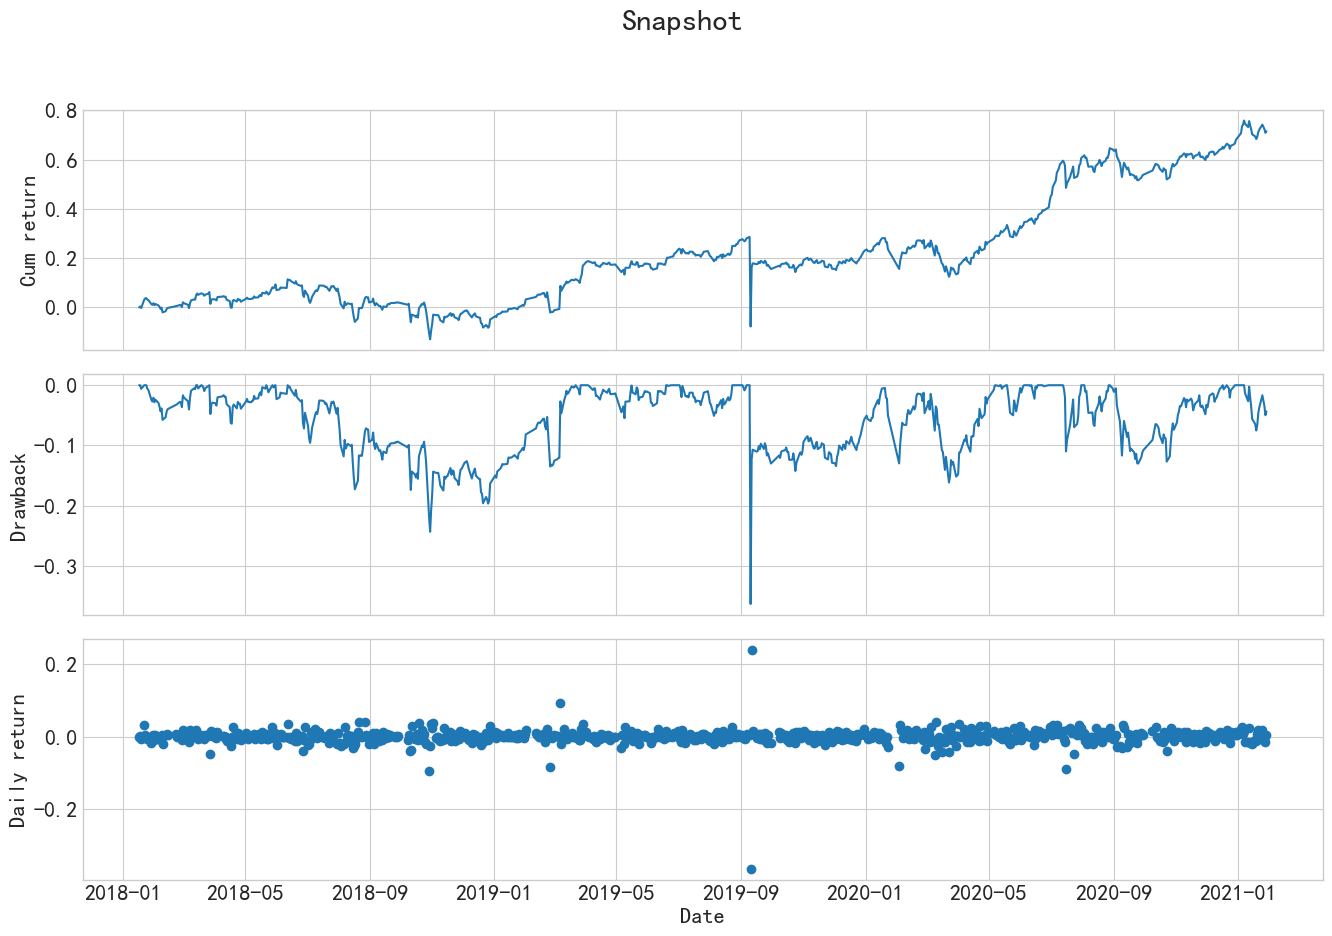

In [27]:
core.plot_rt()

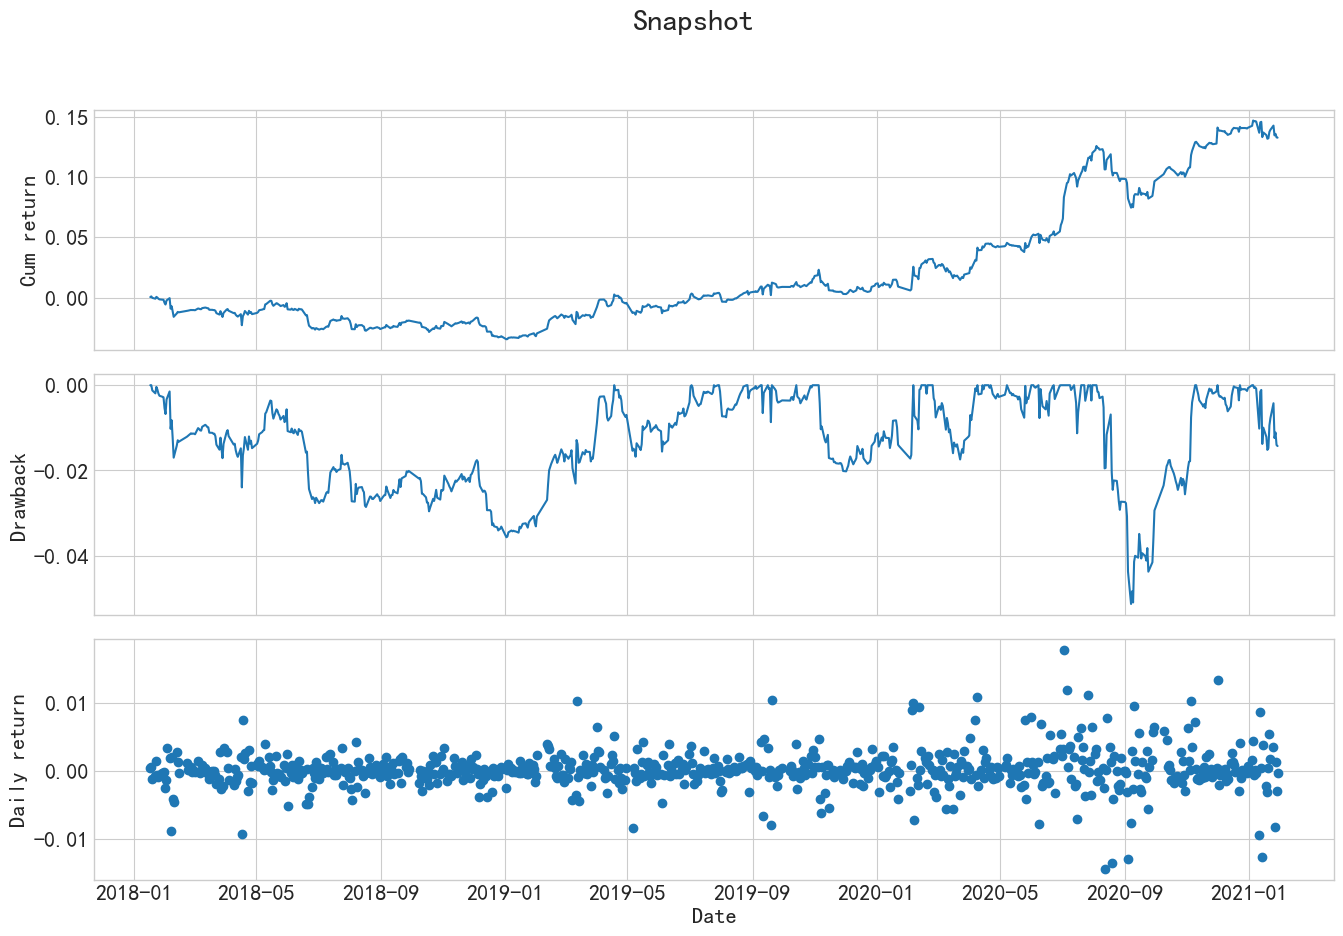

In [20]:
core.strategy[0].plot_rt()

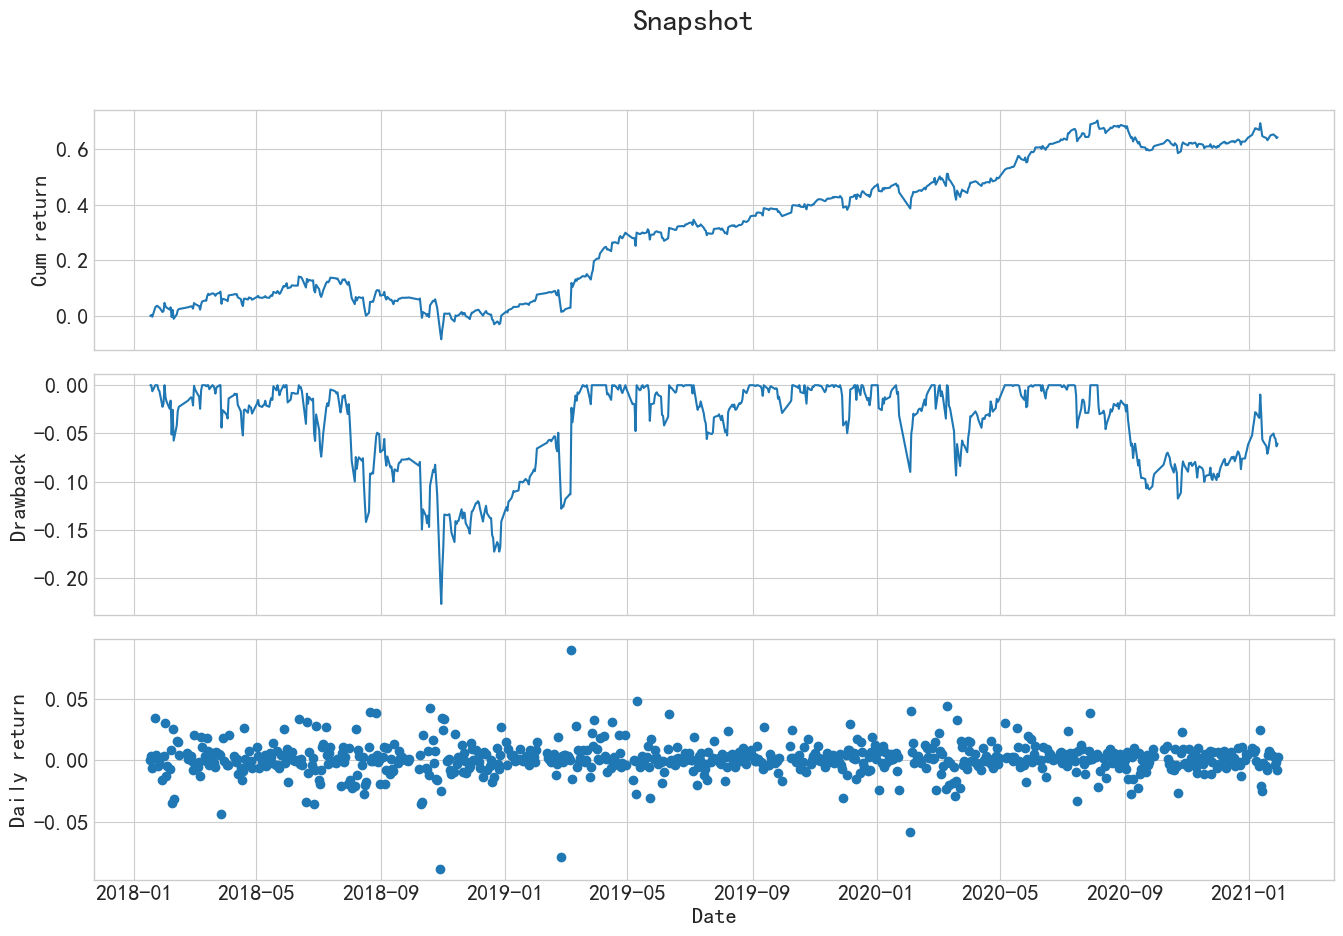

In [21]:
core.strategy[1].plot_rt()

In [23]:
core.balance.sum(axis=1).plot()
core.balance.cash.plot()

In [14]:
import plotly.tools as tls

In [38]:
fig,ax = plt.subplots()
ax.plot(temp.open.values)
pfig = tls.mpl_to_plotly(fig)

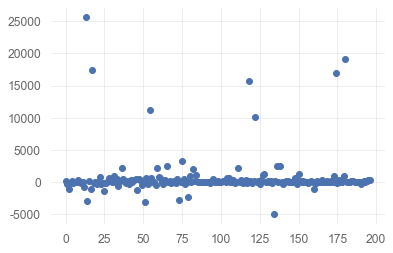

In [37]:
plt.scatter(np.arange(len(core.profit.sum().values)),core.profit.sum().values)

In [33]:
core.profit.sum().sort_values()

600745    -5066.904053
002304    -3138.000000
000596    -2941.000000
300033    -2849.000000
300223    -2420.000000
              ...     
600436    15745.000000
601799    16908.046611
000661    17414.000000
601888    19156.000000
000568    25716.062383
Length: 197, dtype: float64

In [34]:
value=core.balance.sum(axis=1)

In [35]:
drt=(value-value.shift(1))/value

In [36]:
value

2018-01-16    100285.0
2018-01-17    100303.0
2018-01-18    100648.0
2018-01-19    100045.0
2018-01-22    103566.0
                ...   
2021-01-25    249355.0
2021-01-26    247277.0
2021-01-27    244998.0
2021-01-28    241270.0
2021-01-29    242790.0
Length: 740, dtype: float64

In [37]:
drt.mean()/drt.std() * np.sqrt(252)

0.7016402853142563

In [39]:
sharpe(drt)

0.7011657589445185

In [64]:
def getsnapshot(balance):
    value=balance.sum(axis=1)
    drt=((value-value.shift(1))/value).dropna().values
    cumsum = drt.cumsum()
    sup = drt[0]
    drawback = []
    for i in cumsum:
        if i>=sup:
            sup = i
            drawback.append(0)
        else:
            drawback.append(sup-i)
    return drt,cumsum,np.array(drawback)


In [65]:
a,b,c = getsnapshot(core.balance)

In [44]:
core.balance.loc[pd.to_datetime('2019-09-09')].sum()

138975.0

In [45]:
core.balance.loc[pd.to_datetime('2019-09-10')].sum()

101938.0

In [46]:
core.balance.loc[pd.to_datetime('2019-09-11')].sum()

134105.0

In [49]:
core.balance.loc[pd.to_datetime('2019-09-09')][core.balance.loc[pd.to_datetime('2019-09-09')]!=0]

000063     3614.0
000568    25911.0
000596    11399.0
000661    36382.0
000858    13140.0
600188      681.0
600406     1319.0
600436     9814.0
600763     9682.0
600809     5239.0
601799     6824.0
601888     9058.0
601216      241.0
cash       5671.0
Name: 2019-09-09 00:00:00, dtype: float64

In [51]:
core.balance.loc[pd.to_datetime('2019-09-10')][core.balance.loc[pd.to_datetime('2019-09-10')]!=0]

000063     3623.0
000568    17164.0
000596    11297.0
000725      368.0
000858    12945.0
600406     1323.0
600436     9907.0
600547     2661.0
600600     4757.0
600763     9578.0
601377      625.0
601799     6740.0
601888     8977.0
601216      244.0
cash      11729.0
Name: 2019-09-10 00:00:00, dtype: float64

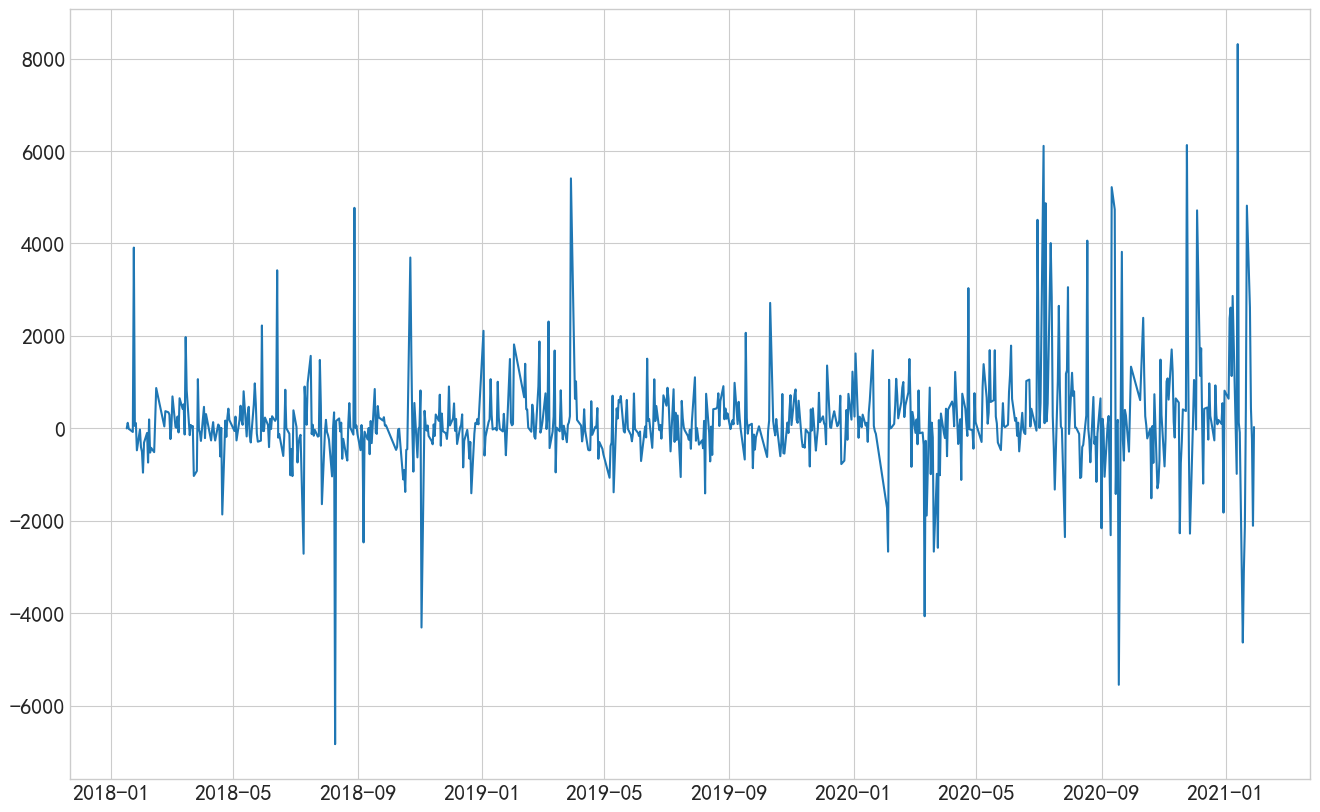

In [85]:
plt.plot(core.profit.sum(axis=1))

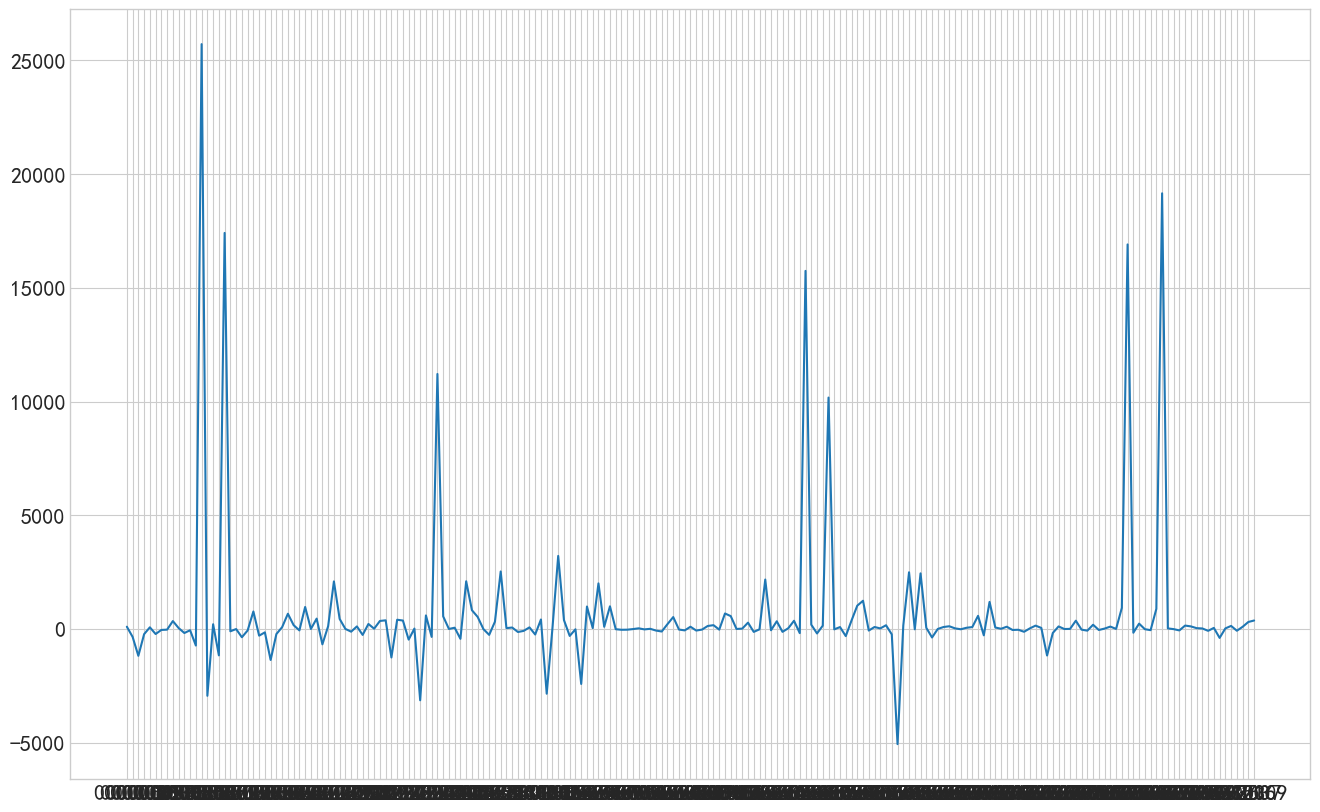

In [79]:
plt.plot(core.profit.sum())

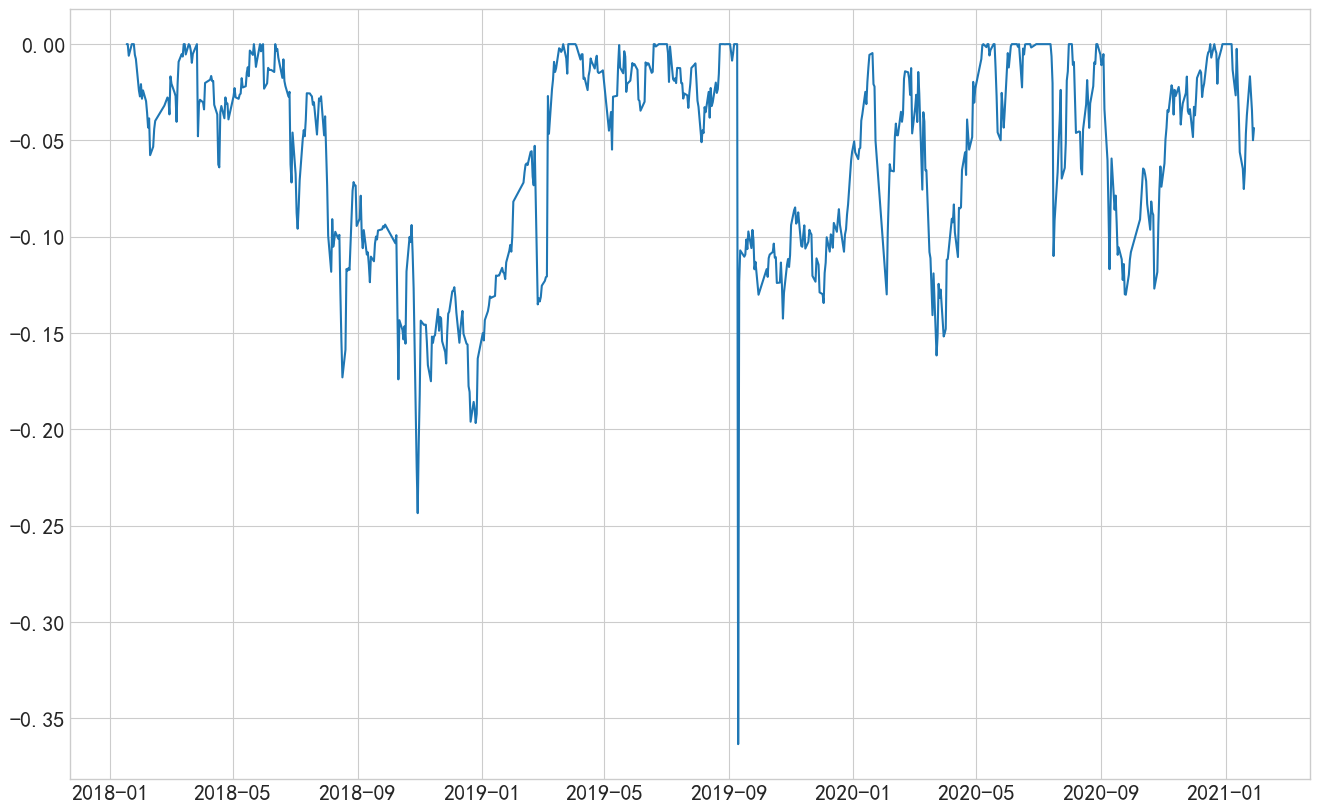

In [66]:
plt.plot(core.balance.index[1:],-c)

qs.plots.snapshot(value,title="Result",figsize=(16, 10))

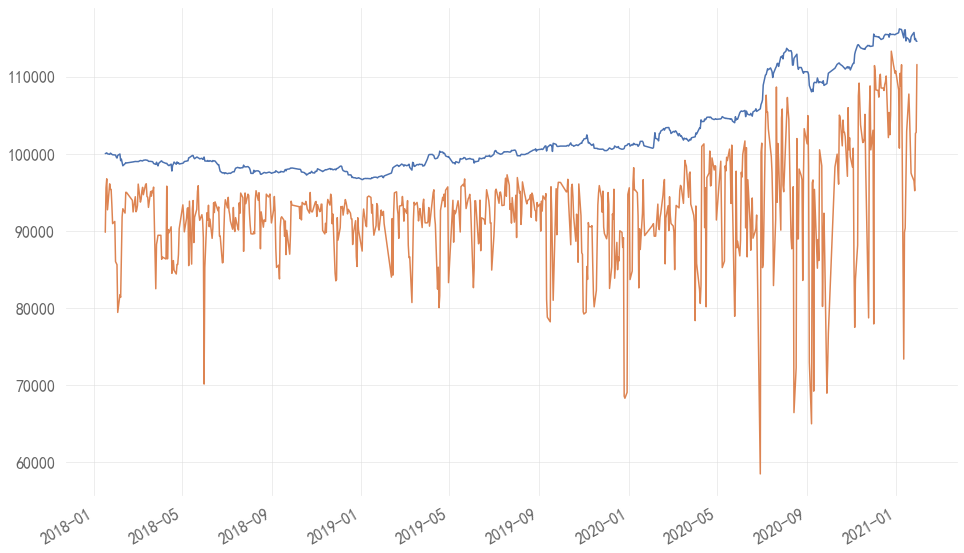

In [47]:
core.strategy[0].balance.sum(axis=1).plot()
core.strategy[0].balance.cash.plot()

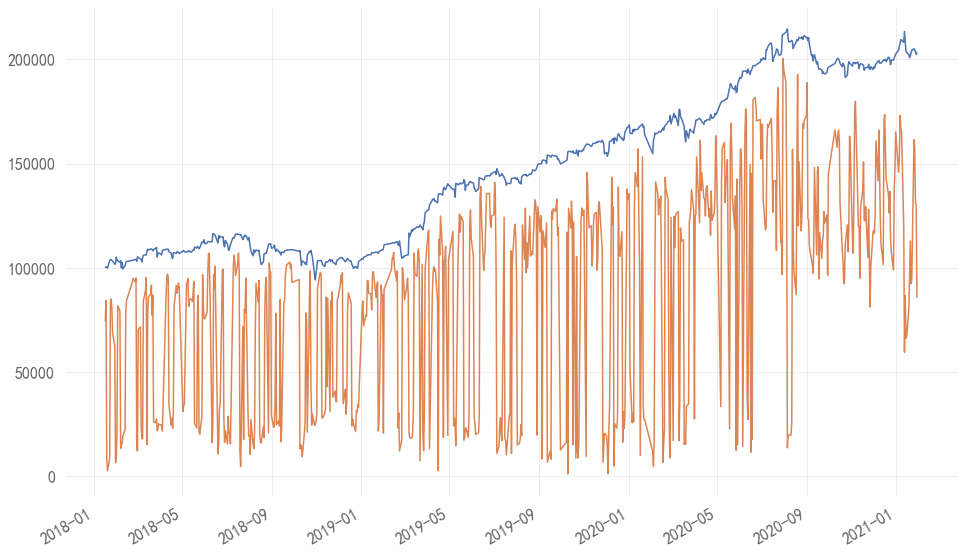

In [42]:
core.strategy[1].balance.sum(axis=1).plot()
core.strategy[1].balance.cash.plot()

In [43]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import iplot,plot

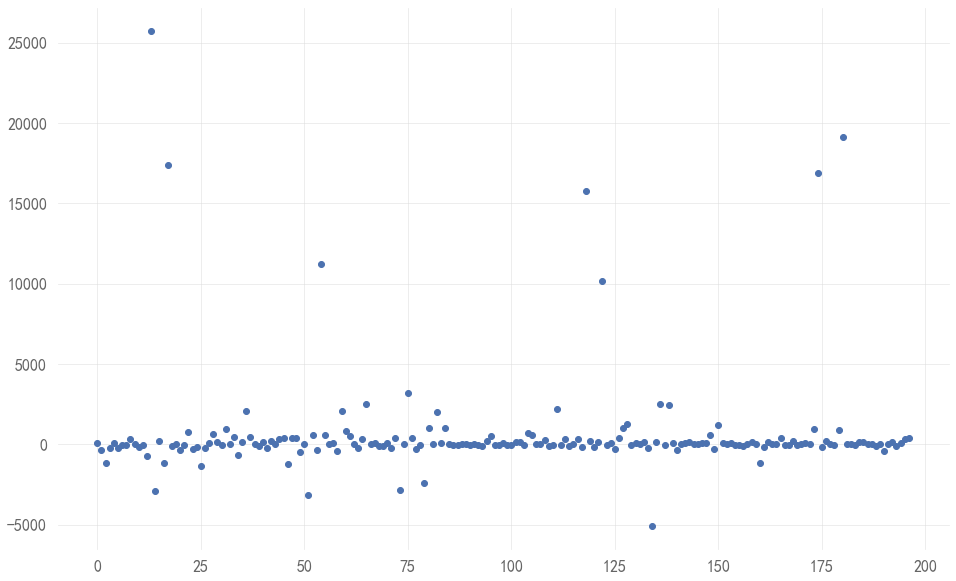

In [44]:
plt.scatter(np.arange(len(core.profit.sum().values)),core.profit.sum().values)

In [45]:
core.profit.sum()

000001      97.0
000002    -349.0
000063   -1183.0
000066    -231.0
000069      71.0
           ...  
600150     132.0
000703     -80.0
601216      93.0
002607     306.0
600309     370.0
Length: 197, dtype: float64

In [46]:
px.scatter(core.profit.sum())

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=core.balance.sum(axis=1),mode='lines'))
fig.add_trace(go.Scatter(y=core.balance.cash,mode='lines'))
fig.show()

In [ ]:
pdata=pd.DataFrame({'Value':core.balance.sum(axis=1),'Cash':core.balance.cash})
px.line(pdata,y=['Value','Cash'])